In [1]:
import pandas as pd
import numpy as np
from ggplot import *
import pandas_profiling
import missingno as msno
import os
%matplotlib inline

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# 1 - Preparing population data

Source has been the world bank: http://data.worldbank.org/indicator/SP.POP.TOTL

In [2]:
dfPopulation = pd.read_excel('../01_OrigData/API_SP.POP.TOTL_DS2_en_excel_v2.xls', skiprows=3)

In [3]:
dfPopulation.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55435.0,56226.0,56697.0,57029.0,57360.0,...,100830.0,101218.0,101342.0,101416.0,101597.0,101936.0,102393.0,102921.0,103441.0,103889.0
1,Andorra,AND,"Population, total",SP.POP.TOTL,13414.0,14376.0,15376.0,16410.0,17470.0,18551.0,...,83373.0,84878.0,85616.0,85474.0,84419.0,82326.0,79316.0,75902.0,72786.0,70473.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8994793.0,9164945.0,9343772.0,9531555.0,9728645.0,9935358.0,...,25183615.0,25877544.0,26528741.0,27207291.0,27962207.0,28809167.0,29726803.0,30682500.0,31627506.0,32526562.0
3,Angola,AGO,"Population, total",SP.POP.TOTL,5270844.0,5367287.0,5465905.0,5565808.0,5665701.0,5765025.0,...,18541467.0,19183907.0,19842251.0,20520103.0,21219954.0,21942296.0,22685632.0,23448202.0,24227524.0,25021974.0
4,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2904780.0,2900247.0,2896652.0,2893654.0,2889167.0


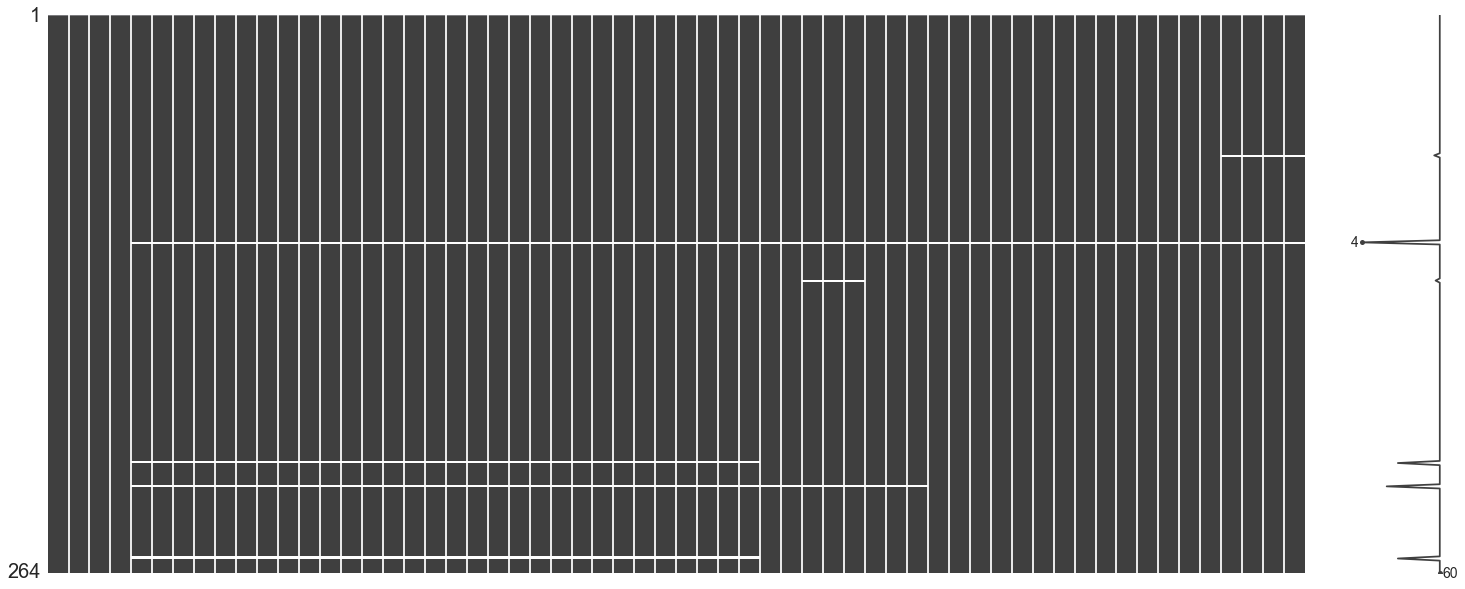

In [4]:
msno.matrix(dfPopulation)

Thus it seems that the data is quite complete besides very few entries

In [5]:
print dfPopulation['Indicator Code'].value_counts()
print dfPopulation['Indicator Name'].value_counts()

SP.POP.TOTL    264
Name: Indicator Code, dtype: int64
Population, total    264
Name: Indicator Name, dtype: int64


Things to do:
<li> Make it flat </li>
<li> Delete unnecessary columns (Indicators) </li>

In [6]:
lstCol_Ids = list(dfPopulation.columns)[:2]
lstCol_Vals = list(dfPopulation.columns)[4:]

In [7]:
print lstCol_Ids
print lstCol_Vals

[u'Country Name', u'Country Code']
[u'1960', u'1961', u'1962', u'1963', u'1964', u'1965', u'1966', u'1967', u'1968', u'1969', u'1970', u'1971', u'1972', u'1973', u'1974', u'1975', u'1976', u'1977', u'1978', u'1979', u'1980', u'1981', u'1982', u'1983', u'1984', u'1985', u'1986', u'1987', u'1988', u'1989', u'1990', u'1991', u'1992', u'1993', u'1994', u'1995', u'1996', u'1997', u'1998', u'1999', u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015']


In [8]:
dfPopulation_out = pd.melt(dfPopulation[lstCol_Ids + lstCol_Vals].copy(), id_vars = lstCol_Ids, value_vars = lstCol_Vals,
                           var_name = 'Year', value_name = 'Population')

In [9]:
lstCountriesWithMissingValues = dfPopulation_out[dfPopulation_out['Population'].isnull()]['Country Name'].unique()
lstCountriesWithMissingValues

array([u'Not classified', u'Serbia', u'Sint Maarten (Dutch part)',
       u'West Bank and Gaza', u'Kuwait', u'Eritrea'], dtype=object)

For those countries from above there are partially entries missing. Let's plot their respective population across the whole time period and see what is missing ...

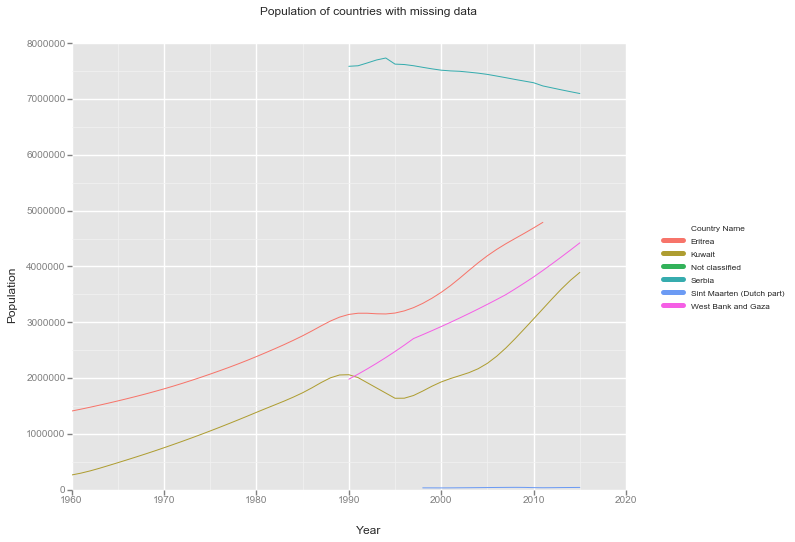

<ggplot: (12946012)>

In [10]:
ggplot(dfPopulation_out[dfPopulation_out['Country Name'].isin(lstCountriesWithMissingValues)],
       aes(x = 'Year', y = 'Population', color = 'Country Name')) + geom_line() + ggtitle('Population of countries with missing data')

As a last check let's see if we have at all data for 'Not classified'

In [11]:
print dfPopulation_out[dfPopulation_out['Country Name'] == 'Not classified']['Population'].min()
print dfPopulation_out[dfPopulation_out['Country Name'] == 'Not classified']['Population'].max()

nan
nan


Thus, we can delete the data for these countries and in theory also for all the others where the data is missing. It won't help in the end if we match to the countries

In [12]:
dfPopulation_out = dfPopulation_out[dfPopulation_out['Population'].notnull()].copy()

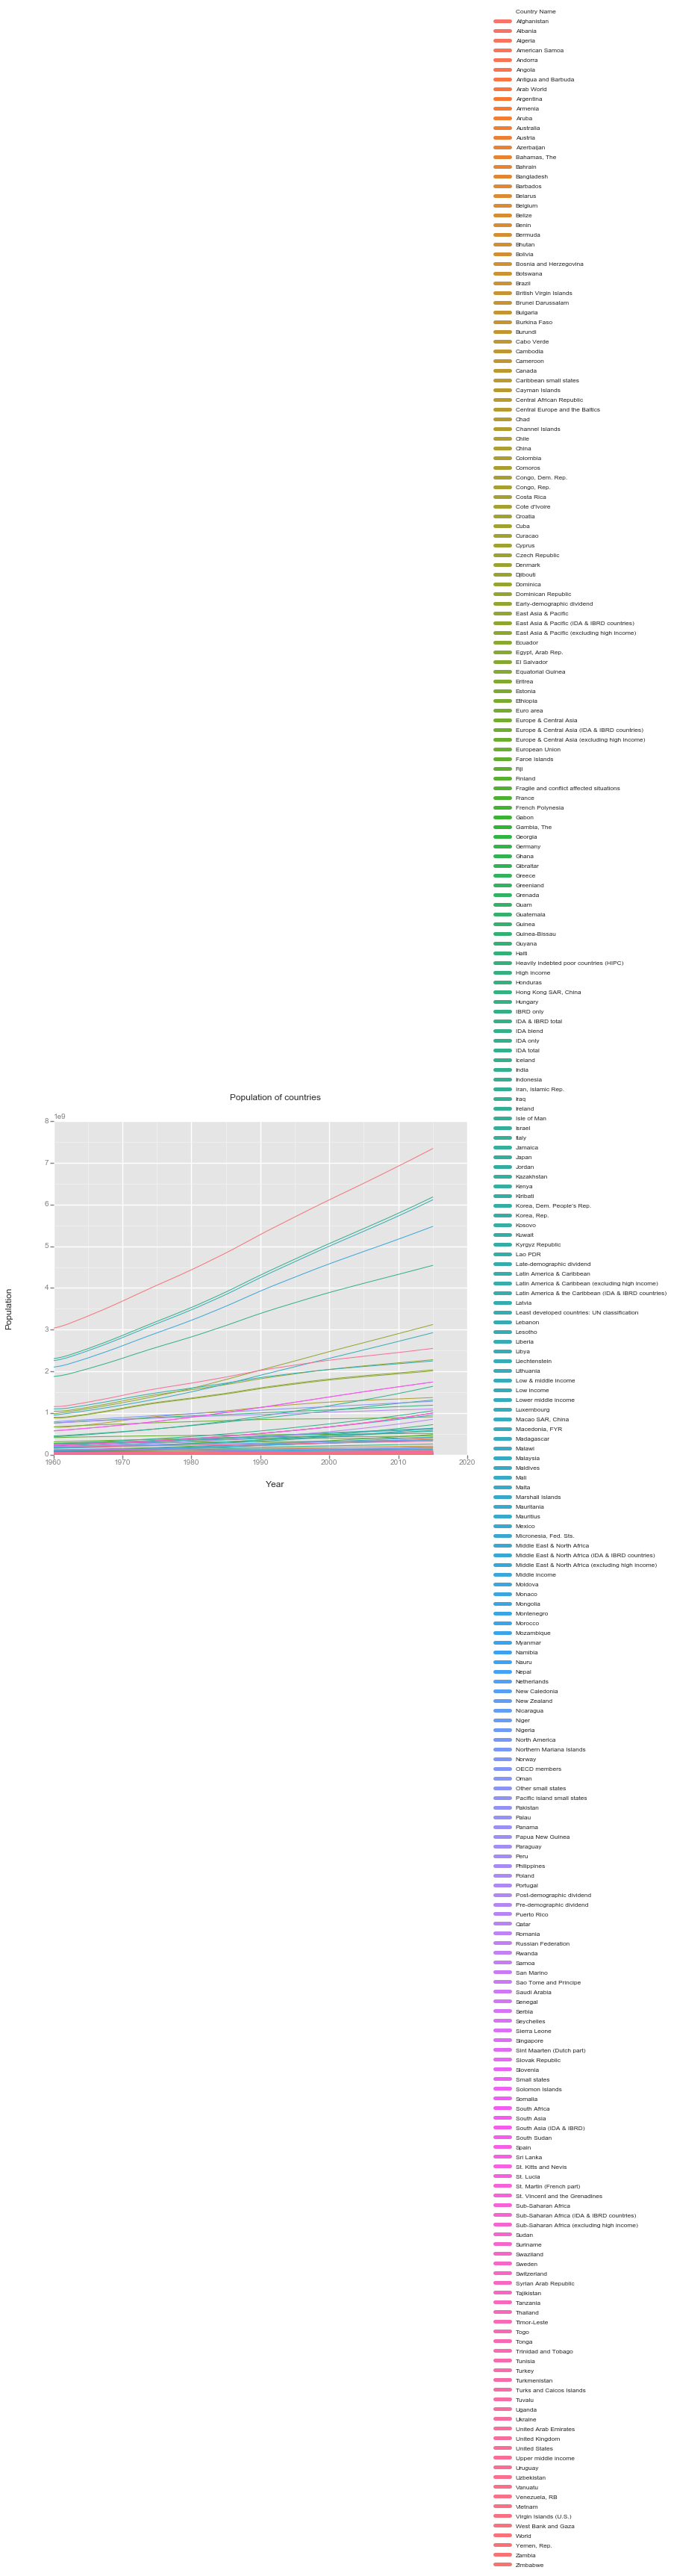

<ggplot: (12940310)>

In [13]:
ggplot(dfPopulation_out,
       aes(x = 'Year', y = 'Population', color = 'Country Name')) + geom_line() + ggtitle('Population of countries')

It actually seems that there is also world population and maybe contintent population in as well

In [14]:
print list(dfPopulation_out['Country Name'].unique())

[u'Aruba', u'Andorra', u'Afghanistan', u'Angola', u'Albania', u'Arab World', u'United Arab Emirates', u'Argentina', u'Armenia', u'American Samoa', u'Antigua and Barbuda', u'Australia', u'Austria', u'Azerbaijan', u'Burundi', u'Belgium', u'Benin', u'Burkina Faso', u'Bangladesh', u'Bulgaria', u'Bahrain', u'Bahamas, The', u'Bosnia and Herzegovina', u'Belarus', u'Belize', u'Bermuda', u'Bolivia', u'Brazil', u'Barbados', u'Brunei Darussalam', u'Bhutan', u'Botswana', u'Central African Republic', u'Canada', u'Central Europe and the Baltics', u'Switzerland', u'Channel Islands', u'Chile', u'China', u"Cote d'Ivoire", u'Cameroon', u'Congo, Rep.', u'Colombia', u'Comoros', u'Cabo Verde', u'Costa Rica', u'Caribbean small states', u'Cuba', u'Curacao', u'Cayman Islands', u'Cyprus', u'Czech Republic', u'Germany', u'Djibouti', u'Dominica', u'Denmark', u'Dominican Republic', u'Algeria', u'East Asia & Pacific (excluding high income)', u'Early-demographic dividend', u'East Asia & Pacific', u'Europe & Central

In [15]:
#To be excluded (manually created from the above)
lstExcluded = ['Arab World', 'Central Europe and the Baltics', 'Caribbean small states',
               u'East Asia & Pacific (excluding high income)', 'Early-demographic dividend', u'East Asia & Pacific',
               u'Europe & Central Asia (excluding high income)', u'Europe & Central Asia', 'Euro area', 'European Union',
               'Fragile and conflict affected situations', 'High income', 'Heavily indebted poor countries (HIPC)', 'IBRD only',
               'IDA & IBRD total', 'IDA total', 'IDA blend', 'IDA only', 'Latin America & Caribbean (excluding high income)',
               'Latin America & Caribbean', u'Least developed countries: UN classification', 'Low income', 'Lower middle income',
               u'Low & middle income', 'Late-demographic dividend', u'Middle East & North Africa', 'Middle income',
               u'Middle East & North Africa (excluding high income)', 'North America', 'OECD members', 'Other small states',
               'Pre-demographic dividend', 'Pacific island small states', 'Post-demographic dividend',
               'Sub-Saharan Africa (excluding high income)', 'Sub-Saharan Africa', 'Small states', 'South Asia',
               u'East Asia & Pacific (IDA & IBRD countries)', u'Europe & Central Asia (IDA & IBRD countries)',
               u'Latin America & the Caribbean (IDA & IBRD countries)', u'Middle East & North Africa (IDA & IBRD countries)',
               u'South Asia (IDA & IBRD)', u'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income', 'World']

In [16]:
dfPopulation_final = dfPopulation_out[~dfPopulation_out['Country Name'].isin(lstExcluded)].copy()

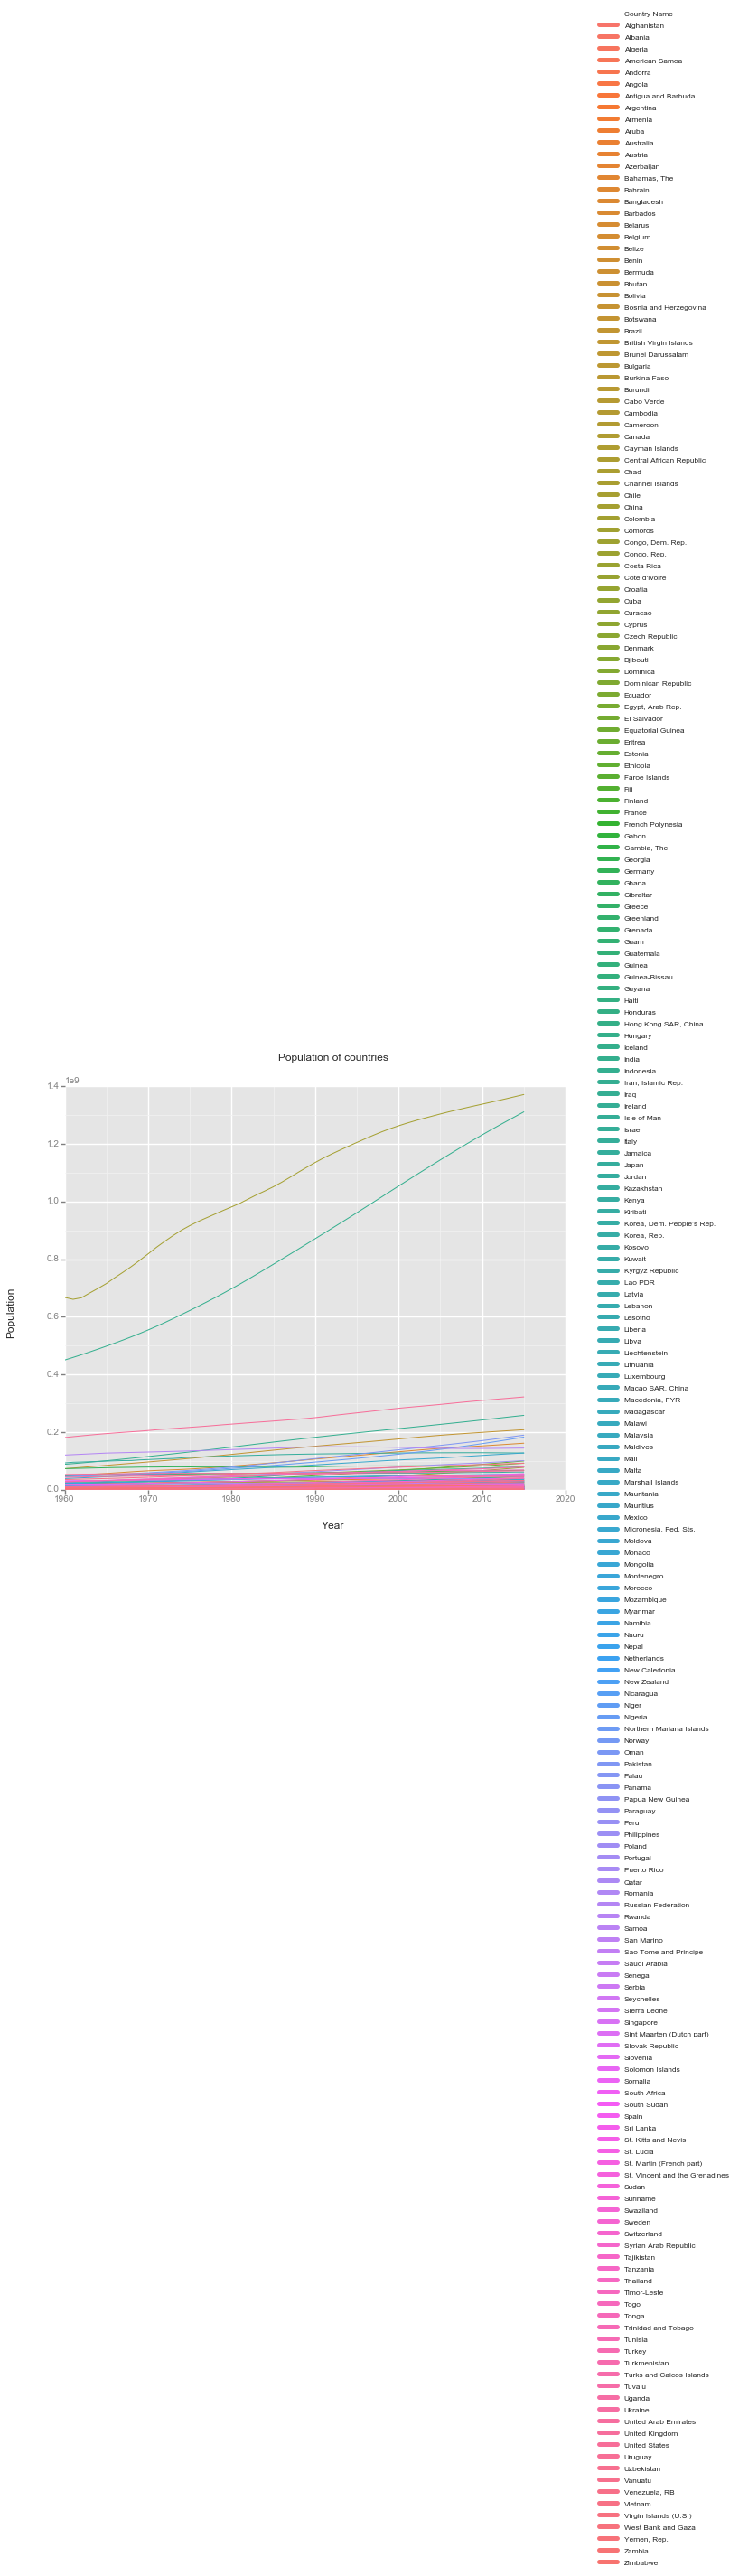

<ggplot: (19132220)>

In [17]:
ggplot(dfPopulation_final,
       aes(x = 'Year', y = 'Population', color = 'Country Name')) + geom_line() + ggtitle('Population of countries')

In [18]:
dfPopulation_final[dfPopulation_final['Population'] == dfPopulation_final.Population.max()]

,Country Name,Country Code,Year,Population
14558,China,CHN,2015,1.371220e+09


In [19]:
lstTop10PopCountries2015 = list(dfPopulation_final[dfPopulation_final['Year'] == '2015'].sort_values('Population', ascending = False).head(10)['Country Name'].unique())
lstTop10PopCountries2015

[u'China',
 u'India',
 u'United States',
 u'Indonesia',
 u'Brazil',
 u'Pakistan',
 u'Nigeria',
 u'Bangladesh',
 u'Russian Federation',
 u'Mexico']

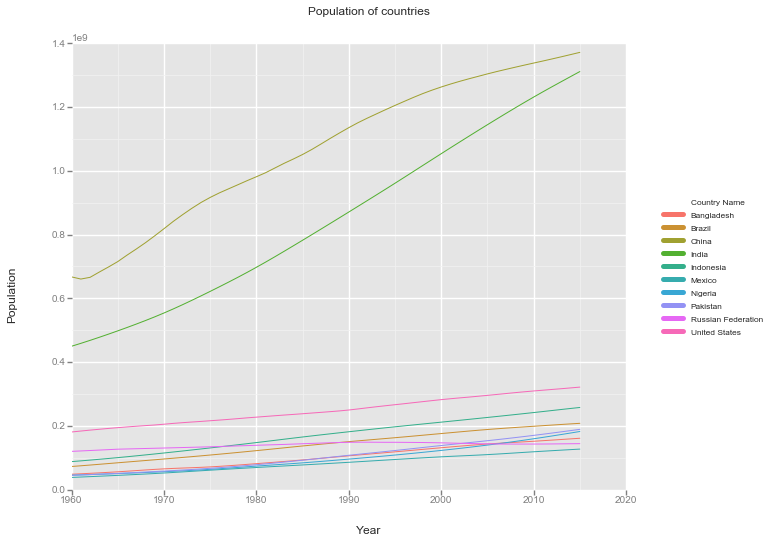

<ggplot: (20648343)>

In [20]:
ggplot(dfPopulation_final[dfPopulation_final['Country Name'].isin(lstTop10PopCountries2015)],
       aes(x = 'Year', y = 'Population', color = 'Country Name')) + geom_line() + ggtitle('Population of countries')

In [21]:
#Due to the fact that it is not possible to write some unicode characters to csv, in this case ´, we change the name for that one
dfPopulation_final['Country Name'] = dfPopulation_final.copy().apply(lambda row: row['Country Name']
                                                                     if row['Country Code'] <> 'PRK'
                                                                     else 'Korea, Dem. Peoples Rep.', axis = 1)

In [22]:
dfPopulation_final.to_csv('../02_FlatData/PopulationByCountry.csv', sep = ';', index = False)

# 2 - Total migration flows

In [23]:
dfMig = pd.read_excel('../01_OrigData/UN_MigFlow_Totals.xlsx', skiprows=16)

In [24]:
dfMig.head()

,CntName,Criteria,Type,Coverage,1980,1981,1982,1983,1984,1985,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Armenia,Residence,Emigrants,Both,..,..,..,..,..,..,...,8451,9303,8053,7461,6121,4100,..,..,..,..
1,Armenia,Residence,Immigrants,Both,..,..,..,..,..,..,...,1514,1497,1335,1112,864,861,..,..,..,..
2,Australia,Residence,Emigrants,Both,90860,85600,92340,100510,96360,93440,...,212200,206690,204800,216580,220280,..,..,..,..,..
3,Australia,Residence,Immigrants,Both,184290,212690,195200,153570,153530,172550,...,350990,363470,402210,460650,535970,..,..,..,..,..
4,Austria,Citizenship,Emigrants,Citizens,..,..,..,..,..,..,...,21703,20333,19387,17828,18168,16376,16059,14401,15443,15368


In [25]:
dfMigMelt = pd.melt(dfMig, list(dfMig.columns)[:4], list(dfMig.columns)[4:], 'Year', 'Migrants')

In [26]:
dfMigMelt.head()

,CntName,Criteria,Type,Coverage,Year,Migrants
0,Armenia,Residence,Emigrants,Both,1980,..
1,Armenia,Residence,Immigrants,Both,1980,..
2,Australia,Residence,Emigrants,Both,1980,90860
3,Australia,Residence,Immigrants,Both,1980,184290
4,Austria,Citizenship,Emigrants,Citizens,1980,..


In [27]:
dfMigMelt = dfMigMelt[dfMigMelt['Migrants'] <> '..']

In [28]:
dfMigMelt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 2 to 7785
Data columns (total 6 columns):
CntName     4218 non-null object
Criteria    4218 non-null object
Type        4218 non-null object
Coverage    4218 non-null object
Year        4218 non-null object
Migrants    4218 non-null object
dtypes: object(6)
memory usage: 230.7+ KB


In [29]:
dfMigMelt['Year'] = dfMigMelt['Year'].copy().astype(int)
dfMigMelt['Migrants'] = dfMigMelt['Migrants'].copy().astype(int)

In [30]:
dfMigMelt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 2 to 7785
Data columns (total 6 columns):
CntName     4218 non-null object
Criteria    4218 non-null object
Type        4218 non-null object
Coverage    4218 non-null object
Year        4218 non-null int32
Migrants    4218 non-null int32
dtypes: int32(2), object(4)
memory usage: 197.7+ KB


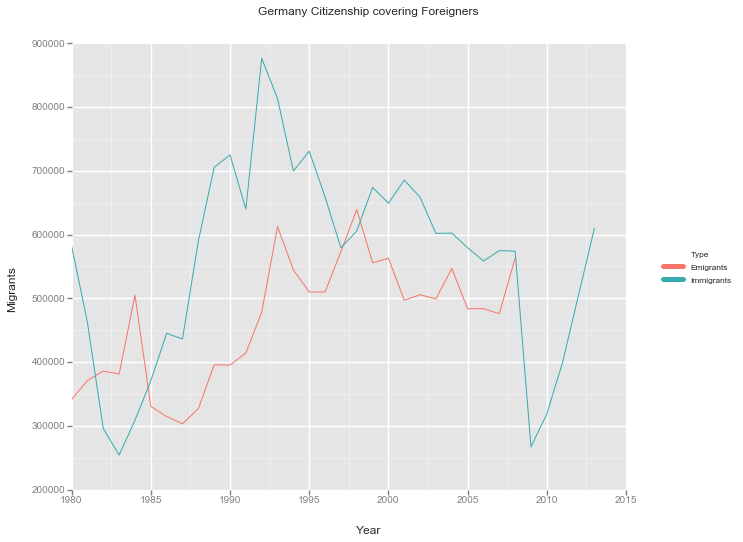

<ggplot: (20779198)>


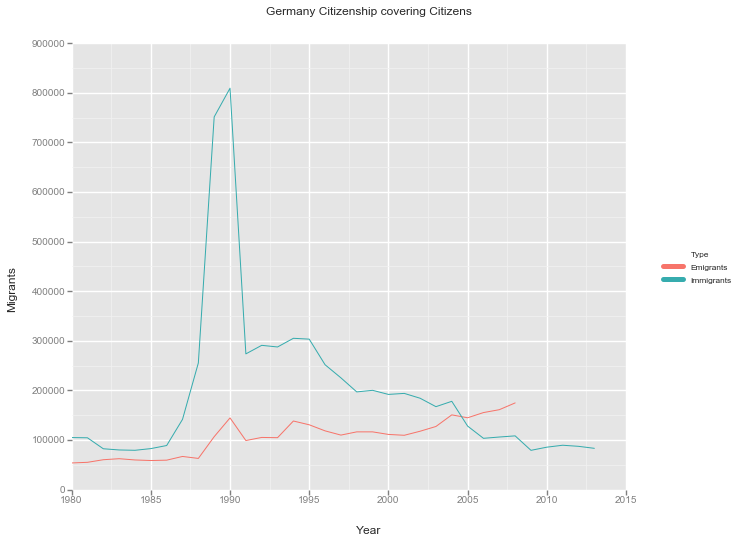

<ggplot: (21893485)>


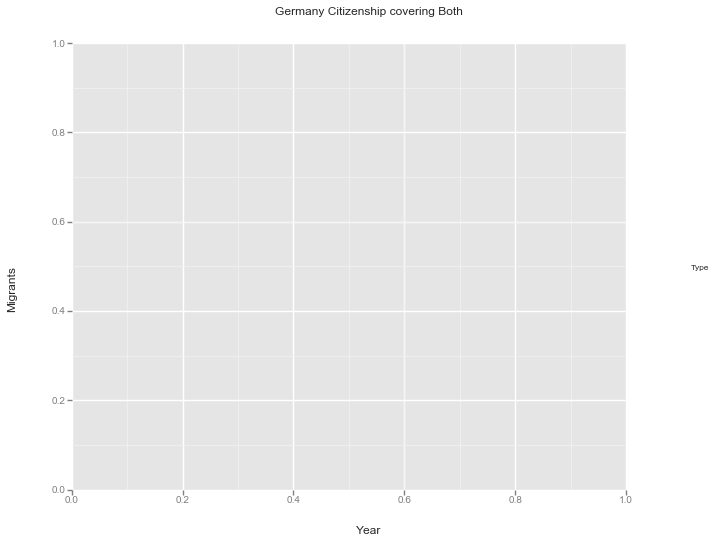

<ggplot: (21962882)>


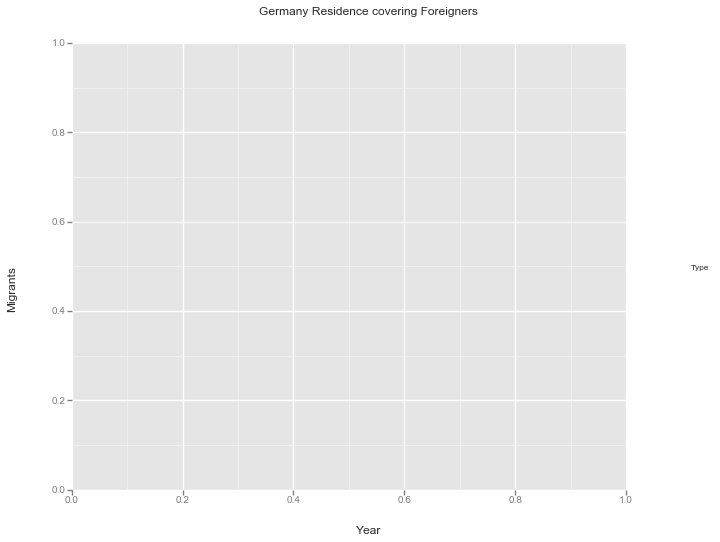

<ggplot: (22215551)>


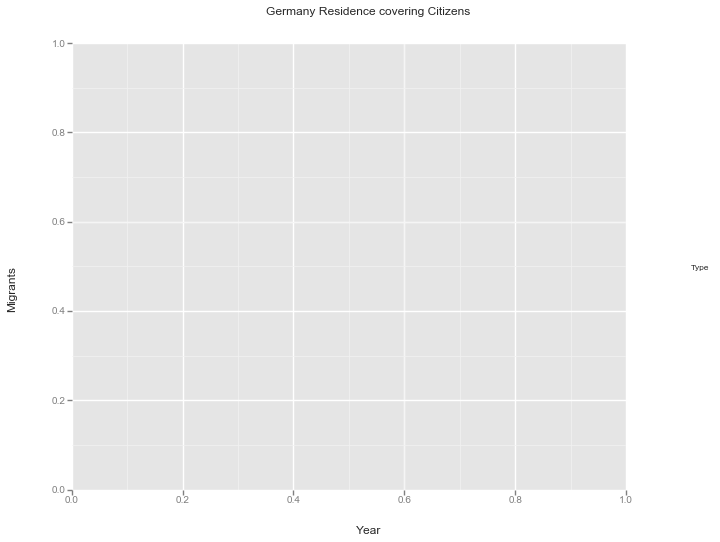

<ggplot: (22349870)>


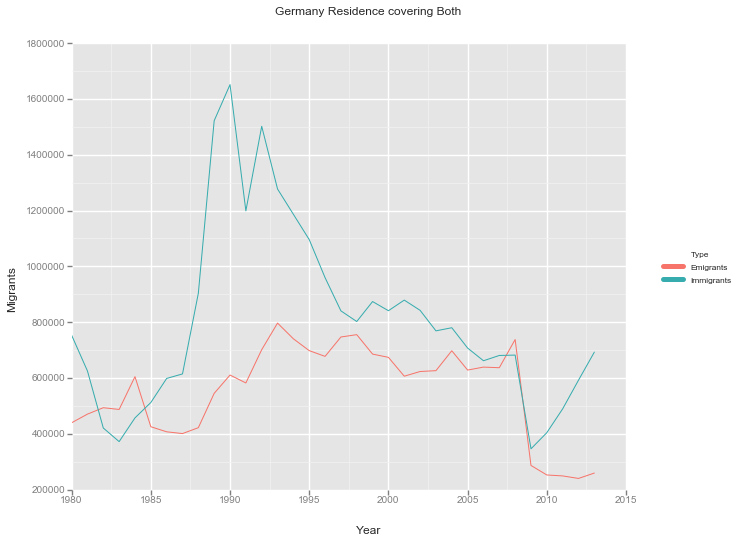

<ggplot: (22452081)>


In [33]:
for cr in ['Citizenship', 'Residence']:
    for co in ['Foreigners', 'Citizens', 'Both']:
        dfx = dfMigMelt[(dfMigMelt['CntName'] == 'Germany') & (dfMigMelt['Criteria'] == cr) & (dfMigMelt['Coverage'] == co)]
        print (ggplot(dfx, aes(x = 'Year', y = 'Migrants', color = 'Type')) + geom_line() +
               ggtitle('Germany ' + cr + ' covering ' + co))

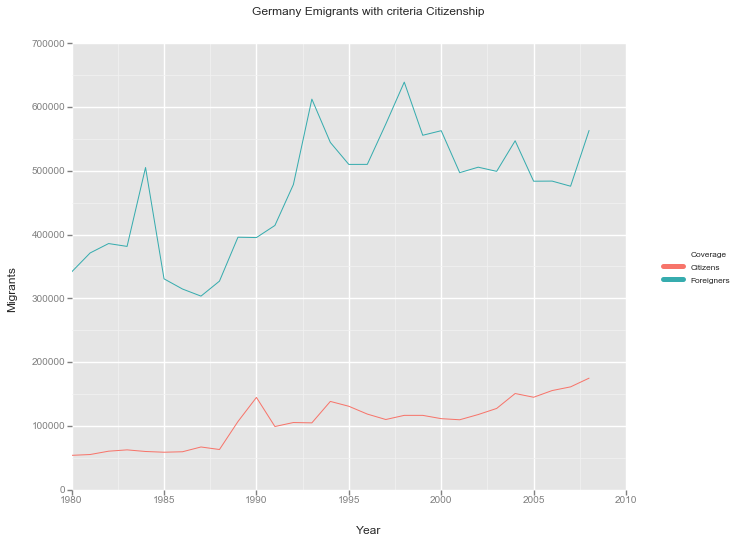

<ggplot: (22623748)>


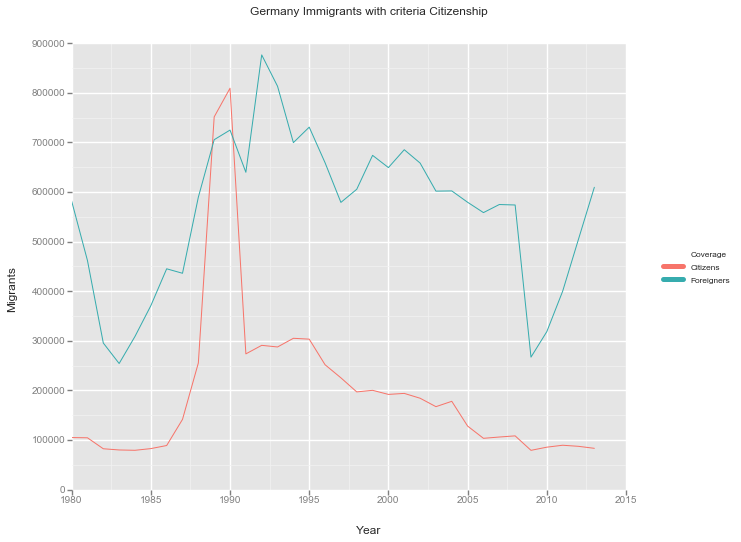

<ggplot: (22745369)>


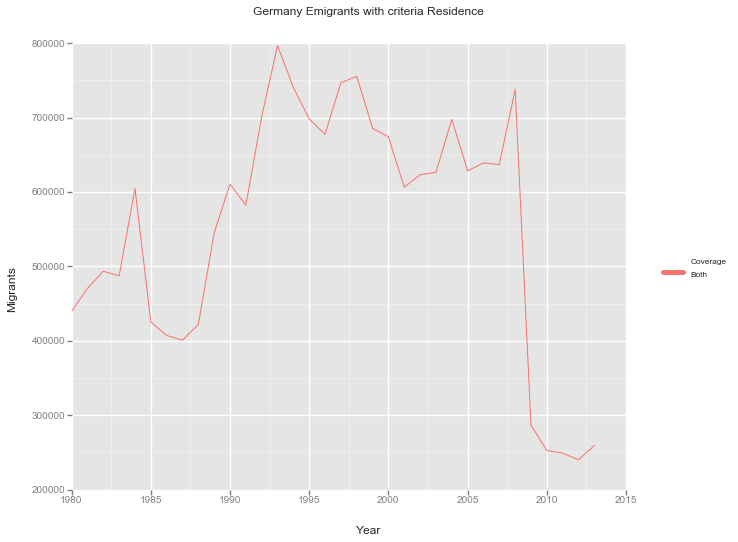

<ggplot: (22723770)>


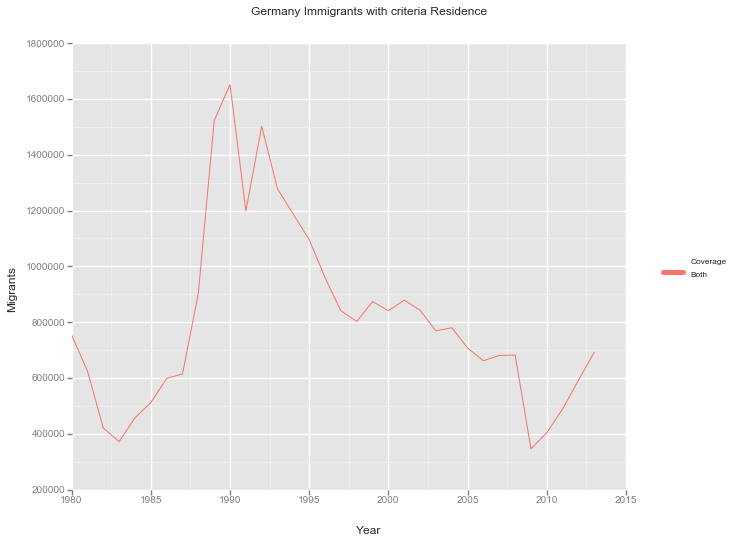

<ggplot: (23370286)>


In [34]:
for cr in ['Citizenship', 'Residence']:
    for ty in ['Emigrants', 'Immigrants']:
        dfx = dfMigMelt[(dfMigMelt['CntName'] == 'Germany') & (dfMigMelt['Criteria'] == cr) & (dfMigMelt['Type'] == ty)]
        print (ggplot(dfx, aes(x = 'Year', y = 'Migrants', color = 'Coverage')) + geom_line() +
               ggtitle('Germany ' + ty + ' with criteria ' + cr))

Looking at this data did not help too much to decide which data for immigrants and emigrants should be taken. Therefore let's see which one has the most data and then select this one.

In [35]:
#1 - Take those values with coverage both
dfMigFinal = dfMigMelt[dfMigMelt['Coverage'] == 'Both']
#2 - Drop where France <> residence
dfMigFinal = dfMigFinal[(dfMigFinal['CntName'] <> 'France') | (dfMigFinal['Criteria'] == 'Residence')]
#3 - Add canada with coverage foreigners
dfMigFinal = dfMigFinal.append(dfMigMelt[(dfMigMelt['CntName'] == 'Canada') & (dfMigMelt['Coverage'] == 'Foreigners')])
#4 - Add New Zealand for Residence
dfMigFinal = dfMigFinal.append(dfMigMelt[(dfMigMelt['CntName'] == 'New Zealand') & (dfMigMelt['Criteria'] == 'Residence')])
#5 - Add US
dfMigFinal = dfMigFinal.append(dfMigMelt[dfMigMelt['CntName'] == 'United States of America'])

In [36]:
dfMigFinal['CntName'].unique()

array([u'Australia', u'Belgium', u'Denmark', u'Finland', u'Germany',
       u'Iceland', u'Luxembourg', u'Netherlands', u'Norway', u'Spain',
       u'Sweden', u'United Kingdom of Great Britain and Northern Ireland',
       u'Italy', u'Greece', u'Ireland', u'Kyrgyzstan', u'Latvia',
       u'Poland', u'Romania', u'Slovenia', u'Croatia',
       u'Russian Federation', u'Cyprus', u'Estonia', u'Lithuania',
       u'Portugal', u'Czech Republic', u'Slovakia', u'Azerbaijan',
       u'Switzerland', u'Austria',
       u'The former Yugoslav Republic of Macedonia', u'Malta', u'France',
       u'Liechtenstein', u'Armenia', u'Belarus', u'Kazakhstan', u'Ukraine',
       u'Republic of Moldova', u'Bulgaria', u'Hungary', u'Canada',
       u'New Zealand', u'United States of America'], dtype=object)

In [37]:
dfMigFinal['CntName'].value_counts()

New Zealand                                             68
Denmark                                                 68
Sweden                                                  68
Finland                                                 68
Norway                                                  67
Germany                                                 67
Italy                                                   61
Iceland                                                 61
Australia                                               58
Ireland                                                 54
Luxembourg                                              49
United Kingdom of Great Britain and Northern Ireland    48
Netherlands                                             47
Spain                                                   46
Romania                                                 44
Belgium                                                 43
Latvia                                                  

In [38]:
dfMigFinal.to_csv('../02_FlatData/MigrationTotal.csv', sep = ';', index = False)

# 3 - Country to country migration flows

In [39]:
len('TfYR of Macedonia by Res')

24

The above it the length of the longest possible sheet name in excel

In [40]:
dfCtryMig = pd.DataFrame()
for f in os.listdir('../01_OrigData/01_MigrationByCountry/'):
    try:
        if f == 'United Kingdom.xlsx':
            name = 'United Kingdom by Residence'
        elif f == 'Canada.xlsx':
            name = 'Canada by Citizenship'
        elif f == 'Czech Republic.xlsx':
            name = 'Czech Republic by Residence'           
        elif f == 'Liechtenstein.xlsx':
            name = 'Liechtenstein by Residence'
        elif f == 'Republic of Moldova.xlsx':
            name = 'Rep of Moldova by Residence'
        elif f == 'Russian Federation.xlsx':
            name = 'Russian Fed by Residence'
        elif f == 'United States of America.xlsx':
            name = 'USA by Place of birth'
        else:
            name = f[:-5] + ' by Residence'
            name = name[:24]
        df = pd.read_excel('../01_OrigData/01_MigrationByCountry/' + f, sheetname= name, skiprows= 20)
        df['Country'] = f[:-5]
        dfCtryMig = dfCtryMig.append(df)
    except:
        print name

In [41]:
dfCtryMig.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Country
0,Emigrants,Both,Australia,909,Oceania,927,Australia and New Zealand,901,Developed regions,..,...,..,..,1,0,1,..,..,..,..,Armenia
1,Emigrants,Both,Azerbaijan,935,Asia,922,Western Asia,902,Developing regions,..,...,..,..,..,860,832,..,..,..,..,Armenia
2,Emigrants,Both,Belarus,908,Europe,923,Eastern Europe,901,Developed regions,..,...,174,147,143,89,32,..,..,..,..,Armenia
3,Emigrants,Both,Canada,905,Northern America,905,Northern America,901,Developed regions,..,...,15,11,12,29,6,..,..,..,..,Armenia
4,Emigrants,Both,Czech Republic,908,Europe,923,Eastern Europe,901,Developed regions,..,...,2,..,2,0,0,..,..,..,..,Armenia


In [42]:
dfCtryMig.Coverage.value_counts()

Both          10823
Foreigners      870
Citizens          1
Name: Coverage, dtype: int64

In [43]:
dfCtryMig[dfCtryMig['Coverage'] <> 'Both']['Country'].value_counts()

New Zealand                 454
United States of America    221
Canada                      196
Name: Country, dtype: int64

In [44]:
dfCtryMig[dfCtryMig['Country'] == 'New Zealand']['Coverage'].value_counts()

Foreigners    454
Name: Coverage, dtype: int64

In [45]:
dfCtryMig[dfCtryMig['Country'] == 'Canada']['Coverage'].value_counts()

Foreigners    195
Citizens        1
Both            1
Name: Coverage, dtype: int64

In [46]:
dfCtryMig[dfCtryMig['Country'] == 'New Zealand']['Coverage'].value_counts()

Foreigners    454
Name: Coverage, dtype: int64

In [47]:
dfTest = dfCtryMig.groupby(['Country', 'OdName', 'Type'], as_index = False)['AreaName'].count()

In [48]:
dfTest['AreaName'].value_counts()

1    11694
Name: AreaName, dtype: int64

This means that we have exactly one origin/destination country for each country which is exactly what we want to have. Thus the only thing left is to limit the df to the relevant columns before we write it into a csv ...

In [49]:
dfCtryMig.columns

Index([    u'Type', u'Coverage',   u'OdName',     u'AREA', u'AreaName',
            u'REG',  u'RegName',      u'DEV',  u'DevName',        1980,
              1981,        1982,        1983,        1984,        1985,
              1986,        1987,        1988,        1989,        1990,
              1991,        1992,        1993,        1994,        1995,
              1996,        1997,        1998,        1999,        2000,
              2001,        2002,        2003,        2004,        2005,
              2006,        2007,        2008,        2009,        2010,
              2011,        2012,        2013,  u'Country'],
      dtype='object')

In [50]:
dfCtryMig.iloc[0]

Type                        Emigrants
Coverage                         Both
OdName                      Australia
AREA                              909
AreaName                      Oceania
REG                               927
RegName     Australia and New Zealand
DEV                               901
DevName             Developed regions
1980                               ..
1981                               ..
1982                               ..
1983                               ..
1984                               ..
1985                               ..
1986                               ..
1987                               ..
1988                               ..
1989                               ..
1990                               ..
1991                               ..
1992                               ..
1993                               ..
1994                               ..
1995                               ..
1996                               ..
1997        

In [51]:
dfCtryMig_final = dfCtryMig[['Country'] + list(dfCtryMig.columns)[:3] + list(dfCtryMig.columns)[9:-1]]

In [52]:
dfCtryMig_final.iloc[0]

Country       Armenia
Type        Emigrants
Coverage         Both
OdName      Australia
1980               ..
1981               ..
1982               ..
1983               ..
1984               ..
1985               ..
1986               ..
1987               ..
1988               ..
1989               ..
1990               ..
1991               ..
1992               ..
1993               ..
1994               ..
1995               ..
1996               ..
1997               ..
1998               ..
1999               ..
2000               ..
2001               ..
2002                1
2003                0
2004                0
2005               ..
2006               ..
2007                1
2008                0
2009                1
2010               ..
2011               ..
2012               ..
2013               ..
Name: 0, dtype: object

In [53]:
#Again we have to care about the fact that not everything can be exported in asci

In [54]:
#Check if there is any issue with the country
for c in dfCtryMig_final.Country.unique():
    try:
        str(c)
    except:
        print c

In [55]:
#Check if there is any issue with the O/D country
lstCountries = []
for c in dfCtryMig_final.OdName.unique():
    try:
        str(c)
    except:
        print c
        lstCountries.append(c)

Côte d'Ivoire
Réunion


In [56]:
dfCtryMig_final[dfCtryMig_final['OdName'].isin(lstCountries)].head()

,Country,Type,Coverage,OdName,1980,1981,1982,1983,1984,1985,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
50,Australia,Emigrants,Both,Côte d'Ivoire,10,0,0,10,0,10,...,0,0,0,0,0,..,..,..,..,..
164,Australia,Emigrants,Both,Réunion,0,0,0,0,0,0,...,0,10,10,10,20,..,..,..,..,..
274,Australia,Immigrants,Both,Côte d'Ivoire,0,0,10,10,10,0,...,10,10,0,0,0,..,..,..,..,..
388,Australia,Immigrants,Both,Réunion,0,0,0,0,0,0,...,40,80,100,120,110,..,..,..,..,..
47,Austria,Emigrants,Both,Côte d'Ivoire,..,..,..,..,..,..,...,8,11,17,7,8,..,10,8,..,..


In [57]:
dictReplacements = {lstCountries[0]: 'Ivory Coast', lstCountries[1]: 'Reunion'}

def ReplaceCtry(x, dct):
    if x in dct:
        return dct[x]
    else:
        return x

dfCtryMig_final['OdName'] = dfCtryMig_final['OdName'].copy().apply(lambda x: ReplaceCtry(x, dictReplacements))

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
dfCtryMig_final[dfCtryMig_final['OdName'].isin(lstCountries)].head()

,Country,Type,Coverage,OdName,1980,1981,1982,1983,1984,1985,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013


Before we export to a csv, we still have to de-pivot the table using melt

In [59]:
dfCtryMig_export = pd.melt(dfCtryMig_final, ['Country', 'Type', 'Coverage', 'OdName'], var_name = 'Year', value_name = 'Migrants')

In [60]:
dfCtryMig_export.head()

,Country,Type,Coverage,OdName,Year,Migrants
0,Armenia,Emigrants,Both,Australia,1980,..
1,Armenia,Emigrants,Both,Azerbaijan,1980,..
2,Armenia,Emigrants,Both,Belarus,1980,..
3,Armenia,Emigrants,Both,Canada,1980,..
4,Armenia,Emigrants,Both,Czech Republic,1980,..


In [61]:
dfCtryMig_export = dfCtryMig_export[dfCtryMig_export['Migrants'] <> '..']

In [62]:
dfCtryMig_export.head()

,Country,Type,Coverage,OdName,Year,Migrants
56,Australia,Emigrants,Both,Afghanistan,1980,0
57,Australia,Emigrants,Both,Albania,1980,0
58,Australia,Emigrants,Both,Algeria,1980,20
59,Australia,Emigrants,Both,American Samoa,1980,10
60,Australia,Emigrants,Both,Andorra,1980,0


In [63]:
dfCtryMig_export.to_csv('../02_FlatData/MigrationPerCountry.csv', sep = ';', index = False)

In [65]:
#Let's check if the imigration/emigration from A to B and B to A are the same ...
dfCtryMigCheck = pd.merge(dfCtryMig_export, dfCtryMig_export, how = 'inner', left_on = ['Country', 'OdName'],
                          right_on = ['OdName', 'Country'])
#we want to compare emigrants with immigrants and not if both are the same ...
dfCtryMigCheck = dfCtryMigCheck[dfCtryMigCheck['Coverage_x'] <> dfCtryMigCheck['Coverage_y']]

In [66]:
dfCtryMigCheck.head()

,Country_x,Type_x,Coverage_x,OdName_x,Year_x,Migrants_x,Country_y,Type_y,Coverage_y,OdName_y,Year_y,Migrants_y
7540,Australia,Emigrants,Both,Canada,1980,2400,Canada,Immigrants,Foreigners,Australia,1980,702
7541,Australia,Emigrants,Both,Canada,1980,2400,Canada,Immigrants,Foreigners,Australia,1981,639
7542,Australia,Emigrants,Both,Canada,1980,2400,Canada,Immigrants,Foreigners,Australia,1982,484
7543,Australia,Emigrants,Both,Canada,1980,2400,Canada,Immigrants,Foreigners,Australia,1983,317
7544,Australia,Emigrants,Both,Canada,1980,2400,Canada,Immigrants,Foreigners,Australia,1984,317


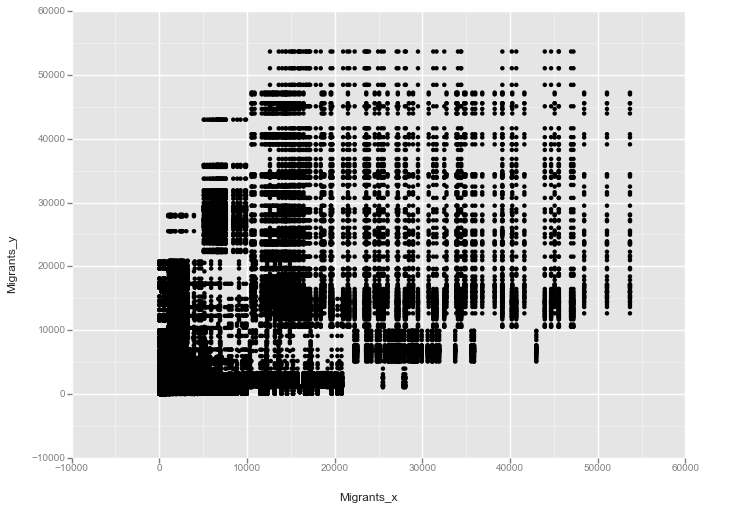

<ggplot: (21955234)>

In [67]:
ggplot(dfCtryMigCheck, aes(x = 'Migrants_x', y = 'Migrants_y')) + geom_point()

At least one can say that this is an interesting picture ;-). But probably we have to ensure that we have each country to country combinatino only once. And it looks as if one value is mapped to another one several times as we have the horizontal and vertical lines ... maybe it is already sufficient when we do the merge also by year ;-)

In [78]:
#Let's check if the imigration/emigration from A to B and B to A are the same ...
dfCtryMigCheck = pd.merge(dfCtryMig_export, dfCtryMig_export, how = 'inner', left_on = ['Country', 'OdName', 'Year'],
                          right_on = ['OdName', 'Country', 'Year'])
#we want to compare emigrants with immigrants and not if both are the same ...
dfCtryMigCheck = dfCtryMigCheck[dfCtryMigCheck['Type_x'] <> dfCtryMigCheck['Type_y']]

In [79]:
dfCtryMigCheck.head()

,Country_x,Type_x,Coverage_x,OdName_x,Year,Migrants_x,Country_y,Type_y,Coverage_y,OdName_y,Migrants_y
1,Australia,Emigrants,Both,Australia,1980,320,Australia,Immigrants,Both,Australia,280
2,Australia,Immigrants,Both,Australia,1980,280,Australia,Emigrants,Both,Australia,320
4,Australia,Emigrants,Both,Canada,1980,2400,Canada,Immigrants,Foreigners,Australia,702
7,Australia,Emigrants,Both,Denmark,1980,190,Denmark,Immigrants,Both,Australia,314
8,Australia,Immigrants,Both,Denmark,1980,620,Denmark,Emigrants,Both,Australia,654


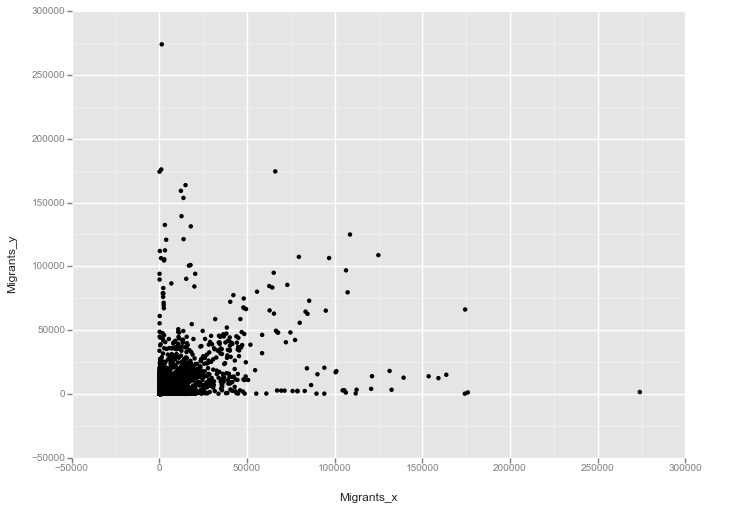

<ggplot: (23741044)>

In [80]:
ggplot(dfCtryMigCheck, aes(x = 'Migrants_x', y = 'Migrants_y')) + geom_point()

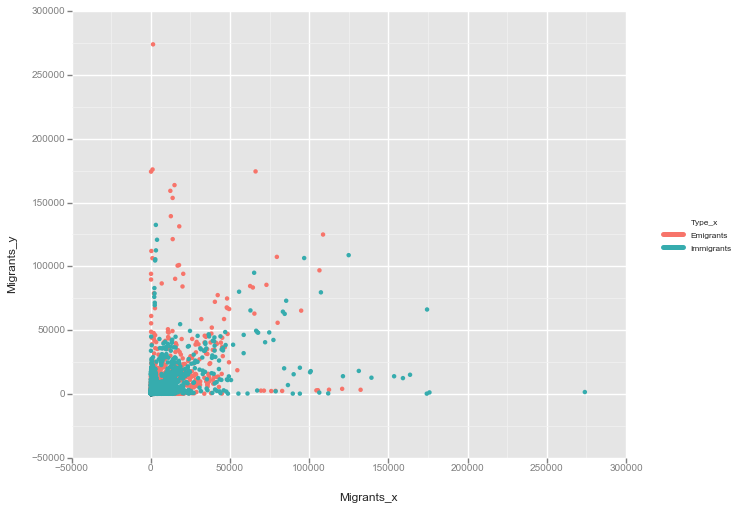

<ggplot: (23264442)>

In [81]:
ggplot(dfCtryMigCheck, aes(x = 'Migrants_x', y = 'Migrants_y', color = 'Type_x')) + geom_point()

One can still see some kind of symmetry which absolutely makes sense as we have Germany -> US emigrants as well as US <- Germany immigrants. But let's see how often we have each value per year

In [85]:
dfCtryMigCheck.groupby(['Country_x', 'OdName_x', 'Type_x', 'Year']).count().head(20)

Coverage_x  Migrants_x  Country_y  \
Country_x OdName_x  Type_x     Year                                      
Armenia   Australia Emigrants  2002           1           1          1   
                               2003           1           1          1   
                               2004           1           1          1   
                               2007           1           1          1   
                               2008           1           1          1   
          Belarus   Emigrants  2000           1           1          1   
                               2001           1           1          1   
                               2002           1           1          1   
                               2003           1           1          1   
                               2004           1           1          1   
                               2005           1           1          1   
                               2006           1           1          1   
                               2007           1           1          1   
                               2008           1           1          1   
                               2009           1           1          1   
                    Immigrants 2000           1           1          1   
                               2001           1           1          1   
                               2002           1           1          1   
                               2003           1           1          1   
                               2004           1           1          1   

                                     Type_y  Coverage_y  OdName_y  Migrants_y  
Country_x OdName_x  Type_x     Year                                            
Armenia   Australia Emigrants  2002       1           1         1           1  
                               2003       1           1         1           1  
                               2004       1           1         1           1  
                               2007       1           1         1           1  
                               2008       1           1         1           1  
          Belarus   Emigrants  2000       1           1         1           1  
                               2001       1           1         1           1  
                               2002       1           1         1           1  
                               2003       1           1         1           1  
                               2004       1           1         1           1  
                               2005       1           1         1           1  
                               2006       1           1         1           1  
                               2007       1           1         1           1  
                               2008       1           1         1           1  
                               2009       1           1         1           1  
                    Immigrants 2000       1           1         1           1  
                               2001       1           1         1           1  
                               2002       1           1         1           1  
                               2003       1           1         1           1  
                               2004       1           1         1           1

Thus more than one per country ... meaning that we should again only take some of the criteria etc. stuff

In [77]:
dfCtryMigCheck[(dfCtryMigCheck['Country_x'] == 'Germany') & (dfCtryMigCheck['Year'] == 1980) & (dfCtryMigCheck['Type_x'] == 'Immigrants')]

,Country_x,Type_x,Coverage_x,OdName_x,Year,Migrants_x,Country_y,Type_y,Coverage_y,OdName_y,Migrants_y
102,Germany,Immigrants,Both,Canada,1980,2913,Canada,Immigrants,Foreigners,Germany,1626
113,Germany,Immigrants,Both,New Zealand,1980,283,New Zealand,Emigrants,Foreigners,Germany,191
114,Germany,Immigrants,Both,New Zealand,1980,283,New Zealand,Immigrants,Foreigners,Germany,283
122,Germany,Immigrants,Both,United States of America,1980,23807,United States of America,Immigrants,Foreigners,Germany,6595


In [90]:
dfCtryMigCheck[(dfCtryMigCheck['Country_x'] == 'United States of America') & (dfCtryMigCheck['Year'] == 1980) & (dfCtryMigCheck['Type_x'] == 'Immigrants')]

,Country_x,Type_x,Coverage_x,OdName_x,Year,Migrants_x,Country_y,Type_y,Coverage_y,OdName_y,Migrants_y
189,United States of America,Immigrants,Foreigners,Australia,1980,1490,Australia,Emigrants,Both,United States of America,9050
192,United States of America,Immigrants,Foreigners,Denmark,1980,504,Denmark,Emigrants,Both,United States of America,2664
194,United States of America,Immigrants,Foreigners,Finland,1980,356,Finland,Emigrants,Both,United States of America,401
196,United States of America,Immigrants,Foreigners,Germany,1980,6595,Germany,Emigrants,Both,United States of America,22576
198,United States of America,Immigrants,Foreigners,New Zealand,1980,729,New Zealand,Emigrants,Foreigners,United States of America,2365
200,United States of America,Immigrants,Foreigners,Norway,1980,403,Norway,Emigrants,Both,United States of America,2446
202,United States of America,Immigrants,Foreigners,Sweden,1980,768,Sweden,Emigrants,Both,United States of America,2145


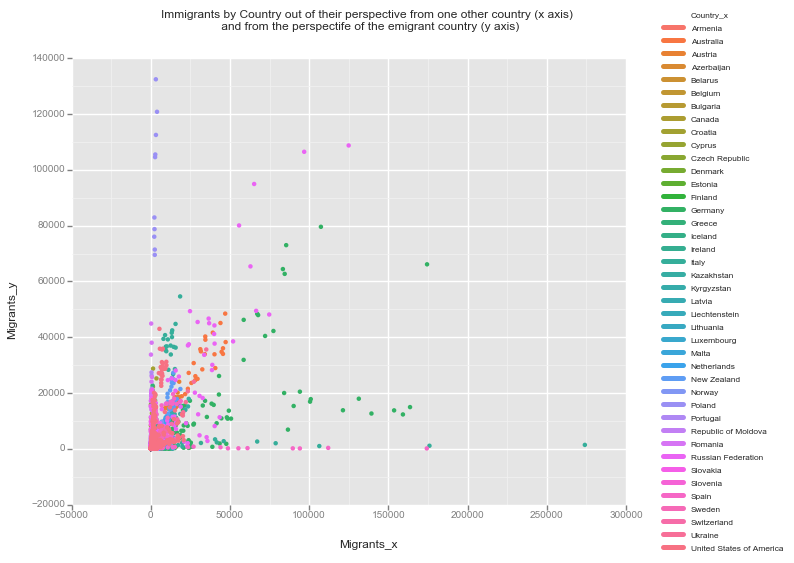

<ggplot: (23264358)>

In [92]:
ggplot(dfCtryMigCheck[dfCtryMigCheck['Type_x'] == 'Immigrants'],
       aes(x = 'Migrants_x', y = 'Migrants_y', color = 'Country_x')) + geom_point() + ggtitle('Immigrants by Country out of their perspective from one other country (x axis) \n and from the perspectife of the emigrant country (y axis)')

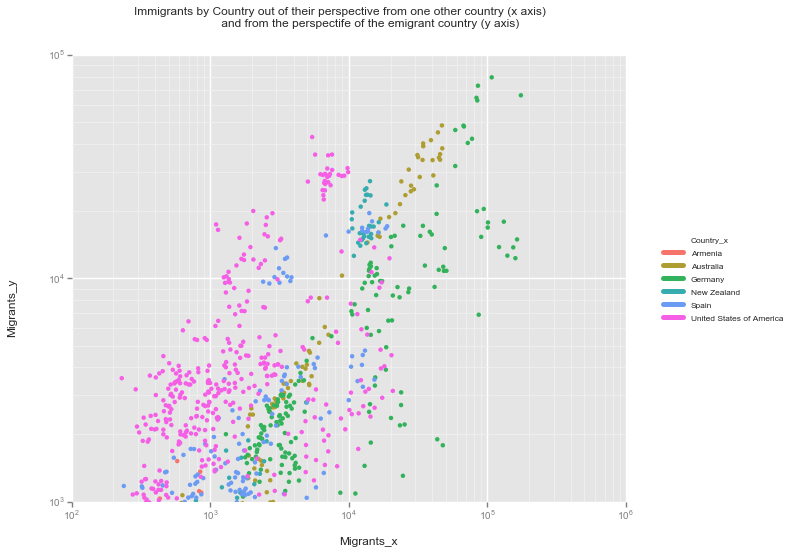

<ggplot: (31173113)>

In [99]:
ggplot(dfCtryMigCheck[(dfCtryMigCheck['Type_x'] == 'Immigrants') &
                      (dfCtryMigCheck['Country_x'].isin(['Germany', 'United States of America', 'Spain',
                                                         'Australia', 'New Zealand', 'Armenia']))],
       aes(x = 'Migrants_x', y = 'Migrants_y', color = 'Country_x')) + geom_point() + \
        ggtitle('Immigrants by Country out of their perspective from one other country (x axis) \
                \n and from the perspectife of the emigrant country (y axis)') + \
    scale_x_log() + scale_y_log()

It looks as if there is a pattern how the countries report their migration: e.g. the US seem in general report less immigrants than the respective other country reports emigrants to the US (besides some single cases where the ratio seems similar ...)

Thus we will just use this data but we have to mention that one cannot compare the data one to one between the different countries

# 4 Align country codes across tables ...

We assume that the list of the population countries is a superset of the list of the countries in the general migration list which is a superset of the countries of the single countries

In [103]:
setCtrPop = set(dfPopulation_final['Country Name'].unique())
setCtrMigTot = set(dfMigFinal['CntName'].unique())
setCtrMigCtryMain = set(dfCtryMig_export['Country'].unique())
setCtrMigCtryOd = set(dfCtryMig_export['OdName'].unique())

In [105]:
#Are the countries with general migration info a subset of the countries with population information?
setCtrMigTot - setCtrPop

{u'Kyrgyzstan',
 u'Republic of Moldova',
 u'Slovakia',
 u'The former Yugoslav Republic of Macedonia',
 u'United Kingdom of Great Britain and Northern Ireland',
 u'United States of America'}

It seems not to be but all of them probably exist in the population stats. I just assume that they are written differently ...

In [106]:
setCtrPop

{u'Afghanistan',
 u'Albania',
 u'Algeria',
 u'American Samoa',
 u'Andorra',
 u'Angola',
 u'Antigua and Barbuda',
 u'Argentina',
 u'Armenia',
 u'Aruba',
 u'Australia',
 u'Austria',
 u'Azerbaijan',
 u'Bahamas, The',
 u'Bahrain',
 u'Bangladesh',
 u'Barbados',
 u'Belarus',
 u'Belgium',
 u'Belize',
 u'Benin',
 u'Bermuda',
 u'Bhutan',
 u'Bolivia',
 u'Bosnia and Herzegovina',
 u'Botswana',
 u'Brazil',
 u'British Virgin Islands',
 u'Brunei Darussalam',
 u'Bulgaria',
 u'Burkina Faso',
 u'Burundi',
 u'Cabo Verde',
 u'Cambodia',
 u'Cameroon',
 u'Canada',
 u'Cayman Islands',
 u'Central African Republic',
 u'Chad',
 u'Channel Islands',
 u'Chile',
 u'China',
 u'Colombia',
 u'Comoros',
 u'Congo, Dem. Rep.',
 u'Congo, Rep.',
 u'Costa Rica',
 u"Cote d'Ivoire",
 u'Croatia',
 u'Cuba',
 u'Curacao',
 u'Cyprus',
 u'Czech Republic',
 u'Denmark',
 u'Djibouti',
 u'Dominica',
 u'Dominican Republic',
 u'Ecuador',
 u'Egypt, Arab Rep.',
 u'El Salvador',
 u'Equatorial Guinea',
 u'Eritrea',
 u'Estonia',
 u'Ethiopia'

This is how it is written in the population data set:
<ul>
    <li>u'Kyrgyz Republic',</li>
    <li>u'Moldova',</li>
    <li>u'Slovak Republic',</li>
    <li>u'Macedonia, FYR',</li>
    <li>u'United Kingdom',</li>
    <li>u'United States'</li>
</ul>

In [107]:
setCtrMigCtryMain - setCtrPop

{'Kyrgyzstan',
 'Republic of Moldova',
 'Slovakia',
 'TfYR of Macedonia',
 'United States of America'}

Again, the issue here seems to be similar as before ...

In [109]:
setCtrMigCtryOd - setCtrPop

{u'Anguilla',
 u'Bahamas',
 u'Bolivia (Plurinational State of)',
 u'China (including Hong Kong Special Administrative Region)',
 u'China, Hong Kong Special Administrative Region',
 u'China, Macao Special Administrative Region',
 u'China, Taiwan Province of China',
 u'Congo',
 u'Cook Islands',
 u"Democratic People's Republic of Korea",
 u'Democratic Republic of the Congo',
 u'Egypt',
 u'Faeroe Islands',
 u'Falkland Islands (Malvinas)',
 u'French Guiana',
 u'Gambia',
 u'Guadeloupe',
 u'Holy See',
 u'Iran (Islamic Republic of)',
 'Ivory Coast',
 u'Kyrgyzstan',
 u"Lao People's Democratic Republic",
 u'Martinique',
 u'Mayotte',
 u'Micronesia (Federated States of)',
 u'Montserrat',
 u'Niue',
 u'Republic of Korea',
 u'Republic of Moldova',
 'Reunion',
 u'Saint Helena',
 u'Saint Kitts and Nevis',
 u'Saint Lucia',
 u'Saint Pierre and Miquelon',
 u'Saint Vincent and the Grenadines',
 u'Slovakia',
 u'State of Palestine',
 u'The former Yugoslav Republic of Macedonia',
 u'Tokelau',
 u'Total',
 u'Un

This now looks already as if it is a little more fun ... Additionally there seems to be a total which should be eliminated ...

In [110]:
dfCtryMig_export[dfCtryMig_export['OdName'].isin(['Total', 'Holy See', 'Unknown'])]

,Country,Type,Coverage,OdName,Year,Migrants
147,Australia,Emigrants,Both,Holy See,1980,0
278,Australia,Emigrants,Both,Unknown,1980,2550
279,Australia,Emigrants,Both,Total,1980,90860
371,Australia,Immigrants,Both,Holy See,1980,0
502,Australia,Immigrants,Both,Unknown,1980,4060
503,Australia,Immigrants,Both,Total,1980,184290
1611,Belgium,Immigrants,Both,Unknown,1980,54294
1612,Belgium,Immigrants,Both,Total,1980,54694
2070,Canada,Immigrants,Foreigners,Unknown,1980,44000
2071,Canada,Immigrants,Both,Total,1980,143137


As a short google research shows, the Holy See is the Vatican. Thus, this one could be kept (even though I do not expect any migration numbers besides to respectively from Switzerland due to the Swiss Guardians). But the 'Total' should be exluded; unknown will be kept as this might be interesting ...

In [112]:
dfCtryMig_export = dfCtryMig_export[dfCtryMig_export['OdName'] <> 'Total']

In [114]:
dfCtryMig_export.to_csv('../02_FlatData/MigrationPerCountry.csv', sep = ';', index = False)

Now let's a look at the remaining missing countries. We will export them to excel as it is quicker to make there the manual adjustments ...

In [118]:
dfManualMapping_1 = pd.DataFrame(list(setCtrMigCtryOd - setCtrPop))
dfManualMapping_2 = pd.DataFrame(list(setCtrPop))
dfManualMapping_1.to_excel('ManualMapping_1.xlsx', index = False)
dfManualMapping_2.to_excel('ManualMapping_2.xlsx', index = False)

In [119]:
dfManualMapping_3 = pd.read_excel('ManualMapping_1_Dict.xlsx')

In [120]:
dfManualMapping_3.head()

,Key,Value
0,Anguilla,NaN
1,Bahamas,"Bahamas, The"
2,Bolivia (Plurinational State of),Bolivia
3,China (including Hong Kong Special Administrat...,China
4,"China, Hong Kong Special Administrative Region","Hong Kong SAR, China"


In [128]:
dctCtryCorr = pd.Series(dfManualMapping_3[dfManualMapping_3['Value'].notnull()]['Value'].values,
          index = dfManualMapping_3[dfManualMapping_3['Value'].notnull()]['Key']).to_dict()

dctCtryCorr[u'TfYR of Macedonia'] = u'Macedonia, FYR'

## Now we update all the countries before we export the files again

In [131]:
#Update migration total
dfMigFinal['CntName'] = dfMigFinal['CntName'].replace(dctCtryCorr)
#Update migration by country - main country
dfCtryMig_export['Country'] = dfCtryMig_export['Country'].replace(dctCtryCorr)
#Update migratino by country - Od country
dfCtryMig_export['OdName'] = dfCtryMig_export['OdName'].replace(dctCtryCorr)

In [134]:
dfCtryMig_export[dfCtryMig_export['OdName'].str.contains('China')]['OdName'].unique()

array([u'China', u'Hong Kong SAR, China', u'Macao SAR, China',
       u'China, Taiwan Province of China'], dtype=object)

In [135]:
dfMigFinal.to_csv('../02_FlatData/MigrationTotal.csv', sep = ';', index = False)
dfCtryMig_export.to_csv('../02_FlatData/MigrationPerCountry.csv', sep = ';', index = False)